
# Feature-based Time Series Classification Machine Learning in `aeon`

Feature-based classifiers and regressors are a popular theme in time series classification (TSC) and regression (TSER). The feature-based learners we provide are simply pipelines of transform and classifier/regressor. They extract descriptive statistics as features from time series to be used in a base estimator. Several toolkits exist for extracting features from time series data, in the first half of this notebook we will introduce a few available in `aeon` and explore them using our EEG dataset example.

 In the second half of the notebook, we will introduce the pipelining utilities available in `aeon` and demonstrate how to build a learner using your own selection of feature extraction transformation algorithm and estimator. Being a `scikit-learn` compatible library, we will also show how the utilities present there can also be used as a substitution for the `aeon` ones.

<img src="./img/pipeline.png" alt="Pipeline classifier."><i>

## Table of Contents

* [Load example data](#load-data)
* [Simple summary statistics](#summary-statistics)
    * [Transforming summary statistics](#summary-statistics-transform)
    * [Classification and regression with summary statistics](#summary-statistics-learner)
* [Catch22](#catch22)
    * [Transforming Catch22](#catch22-transform)
    * [Classification and regression with Catch22](#catch22-learner)
* [TSFresh](#tsfresh)
    * [Transforming TSFresh](#tsfresh-transform)
    * [Classification and regression with TSFresh](#tsfresh-learner)
* [Performance on the UCR univariate classification datasets](#evaluation)
* [Composable pipelines](#pipelines)
* [References](#references)

In [89]:
# There are some deprecation warnings present in the notebook, we will ignore them.
# Remove this cell if you are interested in finding out what is changing soon, for 
# aeon there will be big changes in out v1.0.0 release!
import warnings

warnings.filterwarnings("ignore")


## Load example data <a id='load-data'></a>

In [90]:
from aeon.datasets import load_italy_power_demand

X_train_c, y_train_c = load_italy_power_demand(split="train")
X_test_c, y_test_c = load_italy_power_demand(split="test")
X_test_c = X_test_c[:100]
y_test_c = y_test_c[:100]

print("Train shape:", X_train_c.shape)
print("Test shape:", X_test_c.shape)

Train shape: (67, 1, 24)
Test shape: (100, 1, 24)


(<Figure size 1200x600 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

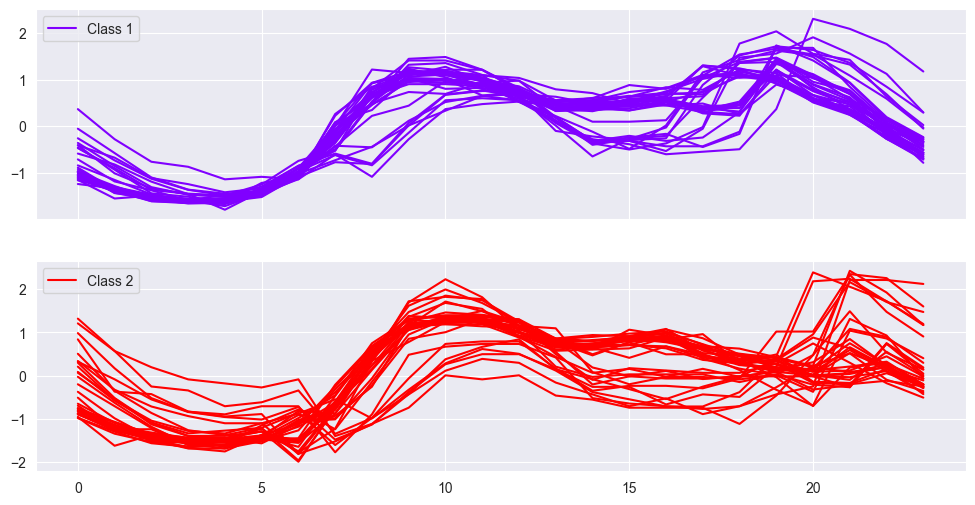

In [91]:
from aeon.visualisation import plot_collection_by_class

plot_collection_by_class(X_train_c, y_train_c)

In [92]:
from aeon.datasets import load_covid_3month

X_train_r, y_train_r = load_covid_3month(split="train")
X_test_r, y_test_r = load_covid_3month(split="test")

print("Train shape:", X_train_r.shape)
print("Test shape:", X_test_r.shape)

Train shape: (140, 1, 84)
Test shape: (61, 1, 84)


(<Figure size 1600x400 with 1 Axes>, <Axes: >)

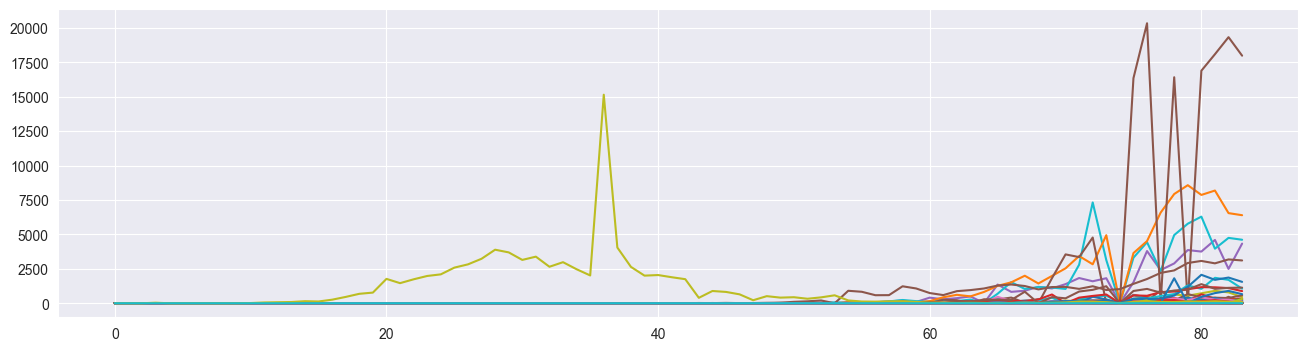

In [93]:
from aeon.visualisation import plot_series_collection

plot_series_collection(X_train_r)

## Simple summary statistics

One of the simplest ways to transform time series data is to calculate simple summary statistics such as the mean, median, minimum and maximum. While unlikely to be the most effective method for classification or regression, they can be an efficient approach if these are all that are required and a useful baseline to compare more complex methods against.

## Transforming summary statistics

There are a myriad of simple summary statistics to extract. `aeon` provides the `SevenNumberSummaryTransformer` to extract some comment sets of simple summary statistics. By default, this will extract the mean, standard deviation, minimum and maximum as well as the 25%, 50% and 75% quartiles of the series.


In [94]:
from aeon.transformations.collection.feature_based import SevenNumberSummaryTransformer

sns = SevenNumberSummaryTransformer()
sns.fit_transform(X_train_c)

array([[-1.04166664e-09,  9.78945015e-01, -1.59308290e+00,
         1.46437540e+00, -8.05078153e-01,  3.02068525e-02,
         9.36412278e-01],
       [-1.95833334e-09,  9.78945019e-01, -1.63091690e+00,
         1.20139250e+00, -9.99388438e-01,  3.84870870e-01,
         7.35719985e-01],
       [-1.77500000e-09,  9.78945007e-01, -1.39711820e+00,
         2.34934410e+00, -7.41487330e-01, -1.32687207e-01,
         2.65374418e-01],
       [-8.54166638e-10,  9.78945010e-01, -1.64645790e+00,
         1.34448740e+00, -8.98721567e-01,  2.66021590e-01,
         7.76495432e-01],
       [-3.41666668e-09,  9.78945015e-01, -1.62024040e+00,
         1.30350160e+00, -9.78061298e-01,  4.05495170e-01,
         6.92648405e-01],
       [ 1.04166668e-09,  9.78945017e-01, -1.13811780e+00,
         2.30312020e+00, -6.40751325e-01, -2.77808270e-01,
         3.94308508e-01],
       [-1.16666667e-09,  9.78945009e-01, -1.75063730e+00,
         1.82296010e+00, -6.14743843e-01, -1.48899820e-02,
         4.4457254

### Classification and regression with summary statistics

The `SummaryClassifier` and `SummaryRegressor` `aeon` classes are wrappers for a pipeline of a `SevenNumberSummaryTransformer` transformation and a `scikit-learn` Random Forest by default.


In [95]:
from aeon.classification.feature_based import SummaryClassifier
from sklearn.metrics import accuracy_score

sns_cls = SummaryClassifier()
sns_cls.fit(X_train_c, y_train_c)
sns_preds_c = sns_cls.predict(X_test_c)
accuracy_score(y_test_c, sns_preds_c)

0.76

The summary feature set and the `scikit-learn` estimator are configurable.

In [ ]:
from sklearn.linear_model import RidgeClassifierCV

sns_cls = SummaryClassifier(
    summary_stats="bowley",
    estimator=RidgeClassifierCV()
)
sns_cls.fit(X_train_c, y_train_c)
sns_preds_c = sns_cls.predict(X_test_c)
accuracy_score(y_test_c, sns_preds_c)

Regression is run similarly to classification.

In [96]:
from aeon.regression.feature_based import SummaryRegressor
from sklearn.metrics import mean_squared_error

sns_reg = SummaryRegressor()
sns_reg.fit(X_train_r, y_train_r)
sns_preds_r = sns_reg.predict(X_test_r)
mean_squared_error(y_test_r, sns_preds_r)

0.0024467568217202175

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

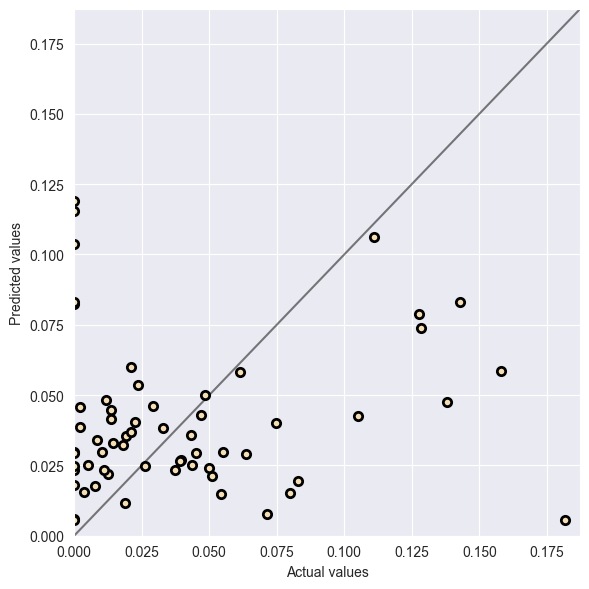

In [97]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_r, sns_preds_r)

## Catch22

The highly comparative time-series analysis (hctsa) [[1,2]](#references) toolbox can create over 7700 features for exploratory time series analysis. 

The canonical time series characteristics (Catch22) [3] are 22 hctsa features determined to be the most discriminatory of the full set. 

The Catch22 were chosen by an evaluation on the UCR datasets. The hctsa features were initially pruned, removing those which are sensitive to mean and variance and any which could not be calculated on over 80\% of the UCR datasets. A feature evaluation was then performed based on predictive performance. Any features which performed below a threshold were removed. For the remaining features, a hierarchical clustering was performed on the correlation matrix to remove redundancy. From each of the 22 clusters formed, a single feature was selected, taking into account balanced accuracy, computational efficiency and interpretability. The Catch22 features cover a wide range of concepts such as basic statistics of data series values, linear correlations, and entropy.

### Transforming Catch22

The `Catch22` class transforms time series into the 22 features.


In [98]:
from aeon.transformations.collection.feature_based import Catch22

c22 = Catch22()
c22.fit_transform(X_train_c)

array([[ 1.15862954e+00, -2.17226684e-01,  8.00000000e+00, ...,
                    nan,  4.00000000e-02,  0.00000000e+00],
       [ 9.18161571e-01, -2.14762211e-01,  1.50000000e+01, ...,
                    nan,  1.11111111e-01,  0.00000000e+00],
       [-2.73179501e-01, -8.58563930e-02,  4.00000000e+00, ...,
                    nan,  3.40136054e-02,  0.00000000e+00],
       ...,
       [ 8.99379969e-01,  7.60180175e-01,  1.60000000e+01, ...,
                    nan,  1.11111111e-01,  0.00000000e+00],
       [-1.21779919e+00, -1.36204195e+00,  1.50000000e+01, ...,
                    nan,  1.11111111e-01,  5.00000000e+00],
       [-5.13158917e-01, -7.23016381e-01,  6.00000000e+00, ...,
                    nan,  1.36054422e-02,  0.00000000e+00]])

The order of the columns matches the `feature_names` list below. 

In [99]:
from aeon.transformations.collection.feature_based._catch22 import feature_names

feature_names

['DN_HistogramMode_5',
 'DN_HistogramMode_10',
 'SB_BinaryStats_diff_longstretch0',
 'DN_OutlierInclude_p_001_mdrmd',
 'DN_OutlierInclude_n_001_mdrmd',
 'CO_f1ecac',
 'CO_FirstMin_ac',
 'SP_Summaries_welch_rect_area_5_1',
 'SP_Summaries_welch_rect_centroid',
 'FC_LocalSimple_mean3_stderr',
 'CO_trev_1_num',
 'CO_HistogramAMI_even_2_5',
 'IN_AutoMutualInfoStats_40_gaussian_fmmi',
 'MD_hrv_classic_pnn40',
 'SB_BinaryStats_mean_longstretch1',
 'SB_MotifThree_quantile_hh',
 'FC_LocalSimple_mean1_tauresrat',
 'CO_Embed2_Dist_tau_d_expfit_meandiff',
 'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
 'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
 'SB_TransitionMatrix_3ac_sumdiagcov',
 'PD_PeriodicityWang_th0_01']

The transform is configurable, and you can select a subset of the `features` to extract. The `catch24` parameter will include the mean and standard deviation as well as the original 22 features.

`use_pycatch22` will use the `pycatch22` C-wrapped library by the original authors to extract features if it is installed.

In [100]:
c22 = Catch22(
    features=["DN_HistogramMode_5", "CO_f1ecac", "SB_MotifThree_quantile_hh", "Mean", "StandardDeviation"],
    catch24=True,
)
c22.fit_transform(X_train_c)

array([[ 1.15862954e+00,  3.00000000e+00,  1.77874751e+00,
        -1.04166664e-09,  9.78945015e-01],
       [ 9.18161571e-01,  4.00000000e+00,  1.73023805e+00,
        -1.95833334e-09,  9.78945019e-01],
       [-2.73179501e-01,  2.00000000e+00,  1.83601155e+00,
        -1.77500000e-09,  9.78945007e-01],
       [ 4.84111110e-02,  4.00000000e+00,  1.60542004e+00,
        -8.54166638e-10,  9.78945010e-01],
       [ 4.26379025e-01,  4.00000000e+00,  1.73023805e+00,
        -3.41666668e-09,  9.78945015e-01],
       [-7.93994009e-01,  3.00000000e+00,  1.83601155e+00,
         1.04166668e-09,  9.78945017e-01],
       [ 3.61613929e-02,  3.00000000e+00,  1.83902118e+00,
        -1.16666667e-09,  9.78945009e-01],
       [ 9.24876690e-01,  4.00000000e+00,  1.73023805e+00,
        -1.25000000e-09,  9.78945013e-01],
       [ 8.39022279e-01,  4.00000000e+00,  1.73023805e+00,
         1.24999998e-09,  9.78945004e-01],
       [ 9.95185971e-01,  4.00000000e+00,  1.48361165e+00,
        -2.45833335e-09

### Classification and regression with Catch22

The `Catch22Classifier` and `Catch22Regressor` classes in `aeon` are simply convenient wrappers for a pipeline of a `Catch22` transformation and a `scikit-learn` Random Forest by default.

In [101]:
from aeon.classification.feature_based import Catch22Classifier
from sklearn.metrics import accuracy_score

c22_cls = Catch22Classifier()
c22_cls.fit(X_train_c, y_train_c)
c22_preds_c = c22_cls.predict(X_test_c)
accuracy_score(y_test_c, c22_preds_c)

0.88

The estimators are also configurable like the `Catch22` transformation. The `estimator` parameter is the estimator to use after transforming the features.

In [102]:
from aeon.classification.sklearn import RotationForestClassifier

c22_cls = Catch22Classifier(
    features=["DN_HistogramMode_5", "CO_f1ecac", "SB_MotifThree_quantile_hh", "Mean", "StandardDeviation"],
    estimator=RotationForestClassifier()
)
c22_cls.fit(X_train_c, y_train_c)
c22_preds_c = c22_cls.predict(X_test_c)
accuracy_score(y_test_c, c22_preds_c)

0.74

Regression is run similarly to classification.

In [103]:
from aeon.regression.feature_based import Catch22Regressor
from sklearn.metrics import mean_squared_error

c22_reg = Catch22Regressor()
c22_reg.fit(X_train_r, y_train_r)
c22_preds_r = c22_reg.predict(X_test_r)
mean_squared_error(y_test_r, c22_preds_r)

0.0019520466047120725

(<Figure size 600x600 with 1 Axes>,
 <Axes: xlabel='Actual values', ylabel='Predicted values'>)

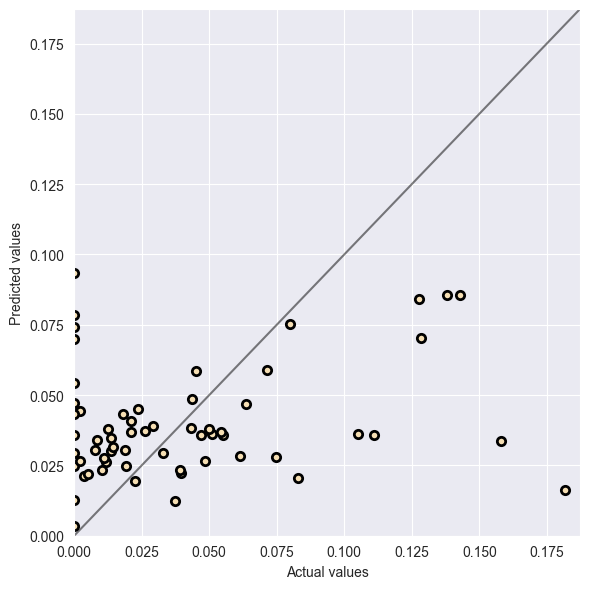

In [104]:
from aeon.visualisation import plot_scatter_predictions

plot_scatter_predictions(y_test_r, c22_preds_r)

## TSFresh

Time series feature extraction based on scalable gypothesis tests (TSFresh) is a collection of just under 800 features extracted from time series. The `aeon` implementation is a wrapper of the `tsfresh` package, and we recommend exploring the original packages documentation for more information on the feature extraction process [4].

### Transforming TSFresh

There are two `aeon` transformation classes for TSFresh. `TSFreshFeatureExtractor` extracts all features, while `TSFreshRelevantFeatureExtractor` extracts only the features that are relevant to the target class using the FRESH algorithm for selection.

In [105]:
from aeon.transformations.collection.feature_based import TSFreshFeatureExtractor

tsf = TSFreshFeatureExtractor()
t = tsf.fit_transform(X_train_c)
t.shape

(67, 777)

In [106]:
t

,dim_0__variance_larger_than_standard_deviation,dim_0__has_duplicate_max,dim_0__has_duplicate_min,dim_0__has_duplicate,dim_0__sum_values,dim_0__abs_energy,dim_0__mean_abs_change,dim_0__mean_change,dim_0__mean_second_derivative_central,dim_0__median,...,dim_0__fourier_entropy__bins_5,dim_0__fourier_entropy__bins_10,dim_0__fourier_entropy__bins_100,dim_0__permutation_entropy__dimension_3__tau_1,dim_0__permutation_entropy__dimension_4__tau_1,dim_0__permutation_entropy__dimension_5__tau_1,dim_0__permutation_entropy__dimension_6__tau_1,dim_0__permutation_entropy__dimension_7__tau_1,dim_0__query_similarity_count__query_None__threshold_0.0,dim_0__mean_n_absolute_max__number_of_maxima_7
0,0.0,0.0,0.0,1.0,-2.500000e-08,23.0,0.413874,0.019186,0.000716,0.030207,...,0.830518,0.937156,1.519383,1.162226,1.671113,2.111631,2.360736,2.582306,0.0,1.416345
1,0.0,0.0,0.0,1.0,-4.700000e-08,23.0,0.306196,0.026626,0.002320,0.384871,...,0.937156,0.937156,1.692409,1.429724,2.136507,2.761626,2.944439,2.890372,0.0,1.420711
2,0.0,0.0,0.0,1.0,-4.260000e-08,23.0,0.435730,0.012217,0.002129,-0.132687,...,0.937156,1.410514,2.204785,1.680460,2.516410,2.857103,2.944439,2.890372,0.0,1.593361
3,0.0,0.0,0.0,1.0,-2.050000e-08,23.0,0.278838,0.023758,-0.000654,0.266022,...,0.687092,0.937156,1.285293,1.570383,2.372350,2.857103,2.944439,2.890372,0.0,1.436927
4,0.0,0.0,1.0,1.0,-8.200000e-08,23.0,0.303270,0.014528,-0.000949,0.405495,...,0.793730,1.043794,1.285293,1.446998,2.083378,2.596834,2.798513,2.890372,0.0,1.452175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.0,1.0,0.0,1.0,-8.120000e-08,23.0,0.310636,0.022933,-0.003269,0.352636,...,0.937156,1.043794,1.631345,1.429724,2.106913,2.718473,2.944439,2.890372,0.0,1.417538
63,0.0,1.0,0.0,1.0,-1.430000e-08,23.0,0.446462,0.013327,-0.008708,0.086211,...,0.793730,0.793730,1.839297,1.424532,2.306336,2.926418,2.944439,2.890372,0.0,1.443685
64,0.0,1.0,0.0,1.0,-2.700000e-08,23.0,0.278311,0.022088,-0.008775,0.456379,...,0.687092,0.937156,1.285293,1.313489,1.988298,2.428581,2.798513,2.890372,0.0,1.399619
65,0.0,0.0,1.0,1.0,-4.500000e-08,23.0,0.323370,0.021558,0.003073,0.184060,...,0.793730,1.178655,1.737983,1.342927,2.017364,2.484367,2.698011,2.813355,0.0,1.411840


In [107]:
from aeon.transformations.collection.feature_based import TSFreshFeatureExtractor

tsf = TSFreshFeatureExtractor(default_fc_parameters="minimal")
t = tsf.fit_transform(X_train_c)
t.shape

(67, 10)

In [108]:
t

,dim_0__sum_values,dim_0__median,dim_0__mean,dim_0__length,dim_0__standard_deviation,dim_0__variance,dim_0__root_mean_square,dim_0__maximum,dim_0__absolute_maximum,dim_0__minimum
0,-2.500000e-08,0.030207,-1.041667e-09,24.0,0.978945,0.958333,0.978945,1.464375,1.593083,-1.593083
1,-4.700000e-08,0.384871,-1.958333e-09,24.0,0.978945,0.958333,0.978945,1.201393,1.630917,-1.630917
2,-4.260000e-08,-0.132687,-1.775000e-09,24.0,0.978945,0.958333,0.978945,2.349344,2.349344,-1.397118
3,-2.050000e-08,0.266022,-8.541667e-10,24.0,0.978945,0.958333,0.978945,1.344487,1.646458,-1.646458
4,-8.200000e-08,0.405495,-3.416667e-09,24.0,0.978945,0.958333,0.978945,1.303502,1.620240,-1.620240
...,...,...,...,...,...,...,...,...,...,...
62,-8.120000e-08,0.352636,-3.383333e-09,24.0,0.978945,0.958333,0.978945,1.215746,1.613336,-1.613336
63,-1.430000e-08,0.086211,-5.958333e-10,24.0,0.978945,0.958333,0.978945,1.312316,1.752948,-1.752948
64,-2.700000e-08,0.456379,-1.125000e-09,24.0,0.978945,0.958333,0.978945,1.177780,1.606217,-1.606217
65,-4.500000e-08,0.184060,-1.875000e-09,24.0,0.978945,0.958333,0.978945,1.378570,1.506285,-1.506285


The FRESH algorithm can be used for feature extraction.

In [109]:
from aeon.transformations.collection.feature_based import TSFreshRelevantFeatureExtractor

tsf = TSFreshRelevantFeatureExtractor()
t = tsf.fit_transform(X_train_c, y_train_c)
t.shape

(67, 102)

In [110]:
t

,"dim_0__fft_coefficient__attr_""imag""__coeff_4",dim_0__energy_ratio_by_chunks__num_segments_10__segment_focus_7,"dim_0__fft_coefficient__attr_""angle""__coeff_2","dim_0__fft_coefficient__attr_""real""__coeff_2","dim_0__cwt_coefficients__coeff_7__w_2__widths_(2, 5, 10, 20)","dim_0__fft_coefficient__attr_""angle""__coeff_4",dim_0__time_reversal_asymmetry_statistic__lag_3,"dim_0__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","dim_0__fft_coefficient__attr_""abs""__coeff_4","dim_0__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)",...,dim_0__number_cwt_peaks__n_1,dim_0__index_mass_quantile__q_0.1,"dim_0__cwt_coefficients__coeff_5__w_5__widths_(2, 5, 10, 20)",dim_0__c3__lag_3,"dim_0__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2",dim_0__index_mass_quantile__q_0.7,dim_0__number_peaks__n_3,"dim_0__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""",dim_0__skewness,dim_0__symmetry_looking__r_0.15000000000000002
0,-0.518648,0.174817,99.099184,-1.884119,-0.364172,-38.752539,0.048835,0.390850,0.828567,-0.429580,...,2.0,0.125000,-2.446099,-0.099180,0.094561,0.625000,2.0,0.970725,-0.161658,1.0
1,-0.685031,0.055423,88.714399,0.200712,-0.524583,-164.605018,0.256011,0.398054,2.580429,0.053826,...,3.0,0.083333,-3.241700,0.080131,0.076549,0.541667,2.0,0.650850,-0.540979,1.0
2,3.974551,0.063383,32.676388,8.155039,-1.036267,110.065350,-0.468040,0.168591,4.231388,0.750226,...,4.0,0.083333,-0.219809,0.127836,-0.040141,0.916667,0.0,0.927146,1.119547,1.0
3,1.394742,0.024835,65.138247,2.627806,-1.155282,141.966896,-0.133962,0.166803,2.263762,0.200741,...,3.0,0.125000,-3.562155,0.139720,-0.206107,0.541667,1.0,0.654654,-0.474711,1.0
4,-0.379805,0.117074,108.914275,-2.505609,-0.151285,-106.826437,0.316311,0.332054,0.396794,-0.339408,...,3.0,0.083333,-3.049528,0.096878,0.016707,0.666667,2.0,0.505367,-0.536024,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,-1.619529,0.073010,90.834440,-0.131633,-0.333439,-133.897886,0.024439,0.340449,2.247546,0.026455,...,3.0,0.083333,-3.057479,0.080502,0.065932,0.541667,2.0,0.572856,-0.476189,1.0
63,3.583705,0.001157,50.419593,5.385285,-1.066064,111.051724,0.196337,0.344842,3.840000,0.794328,...,4.0,0.125000,-3.679130,0.051191,-0.114947,0.583333,2.0,0.743996,-0.366745,1.0
64,-1.390292,0.037709,85.172131,0.673320,-0.445890,-142.293744,0.187180,0.337331,2.273154,0.422435,...,2.0,0.083333,-3.251520,0.090423,-0.040642,0.541667,1.0,0.510829,-0.542321,0.0
65,2.966799,0.003888,54.469453,3.984675,-1.350784,128.310791,0.016076,0.265947,3.781001,0.484924,...,3.0,0.125000,-3.704236,0.103337,0.072121,0.541667,1.0,0.744815,-0.314436,1.0


### Classification and regression with TSFresh

In [111]:
from aeon.classification.feature_based import TSFreshClassifier
from sklearn.metrics import accuracy_score

tsf_cls = TSFreshClassifier()
tsf_cls.fit(X_train_c, y_train_c)
tsf_preds_c = tsf_cls.predict(X_test_c)
accuracy_score(y_test_c, tsf_preds_c)

0.98

Regression is run similarly to classification, with feature selection available for both learning tasks.

In [112]:
from aeon.regression.feature_based import TSFreshRegressor

tsf_reg = TSFreshRegressor()
tsf_reg.fit(X_train_r, y_train_r)
tsf_preds_r = tsf_reg.predict(X_test_r)
mean_squared_error(y_test_r, tsf_preds_r)

0.0019998715745554777

An extensive comparison of feature-based pipelines [3] found that TSFresh using its `"comprehensive"` feature set followed by a Rotation Forest classifier [4] was significantly more accurate than other combinations. This configuration is hard coded into an `aeon` estimator called the FreshPRINCE.

In [113]:
from aeon.classification.feature_based import FreshPRINCEClassifier
from sklearn.metrics import accuracy_score

fp = FreshPRINCEClassifier()
fp.fit(X_train_c, y_train_c)
fp_preds = fp.predict(X_test_c)
accuracy_score(y_test_c, fp_preds)

0.9

## Performance on the UCR univariate classification datasets

Below we show the performance of the `Catch22Classifier`, `TSFreshClassifier` and `FreshPRINCEClassifier` pipelines on the UCR TSC archive datasets [?]. The results files are stored on [timeseriesclassification.com].

In [114]:
from aeon.benchmarking import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

names = ["Catch22", "TSFresh", "FreshPRINCE"]
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 3)

In [115]:
import numpy as np

np.mean(results, axis=0)

array([0.78136831, 0.78275687, 0.84159997])

(<Figure size 600x220 with 1 Axes>, <Axes: >)

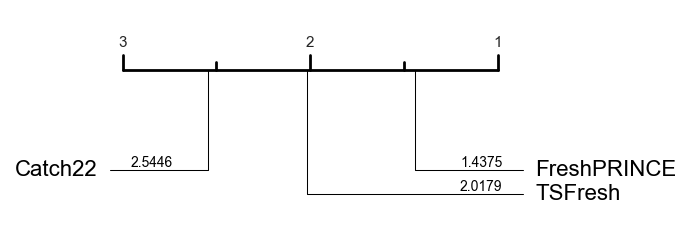

In [116]:
from aeon.visualisation import plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

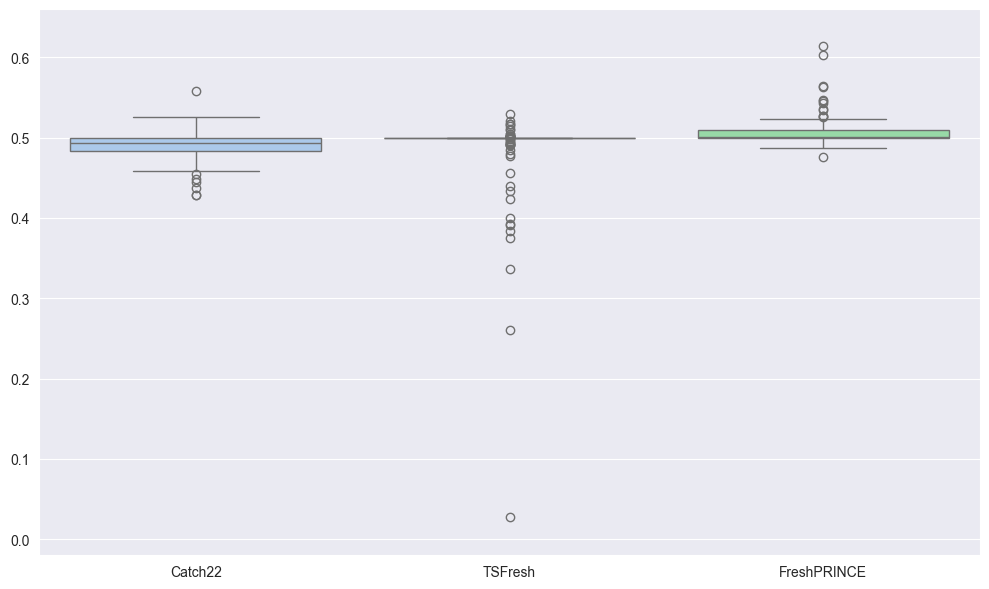

In [117]:
from aeon.visualisation import plot_boxplot_median

plot_boxplot_median(results, names, plot_type="boxplot")

## Composable pipelines <a id='pipelines'></a>

<a id='references'></a>
## References

[1] htsc repo https://github.com/benfulcher/hctsa

[2] Christ,  et al.  (2018) "Time series feature extraction on basis of scalable
hypothesis tests (tsfresh–a python package)." Neurocomputing 307: 72-77.
        https://www.sciencedirect.com/science/article/pii/S0925231218304843

[3] Midddlehurst and Bagnall (2022) "The FreshPRINCE: A Simple Transformation Based
Pipeline Time Series Classifier" https://arxiv.org/abs/2201.12048

[4] Rodriguez et al. (2006) "Rotation Forest: A New Classifier Ensemble Method" IEEE
Transactions on Pattern Analysis and Machine Intelligence, 28(10): 1619--1630.

[5] Morrill et al. (2020) "A generalised signature method for multivariate time series
feature extraction" https://arxiv.org/abs/2006.00873
